In [2]:
# This script fetches weather data from a given URL, processes it to identify the header row,
# and loads it into a pandas DataFrame for further analysis and visualization.
# Author: Dima Kozlovskyy


# Import necessary libraries.
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Getting Data

In [3]:
# Define the URL for the weather data CSV file.
url = "https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv"

In [4]:
# Geeting ready the data to load into DataFrame by identifying the header row number.

lines = requests.get(url).text.splitlines()

start_header = 0
i = 0

# Loop through lines to find the header row (the first line with more than one comma).
for line in lines:
    commas = re.findall(r',', line)
    if len(commas) > 1:
        start_header = i
        break
    i += 1

print(f"Header starts at line: {start_header}") # Will give the output of 23.

Header starts at line: 23


In [5]:
# Now we can use skiprows with 23.
df = pd.read_csv("https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv", skiprows=start_header)

df.columns

/tmp/ipykernel_2733/1956283021.py:2: DtypeWarning: Columns (2,10,12,14,15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv", skiprows=start_header)


Index(['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt',
       'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir', 'ww', 'w',
       'sun', 'vis', 'clht', 'clamt'],
      dtype='object')

/tmp/ipykernel_2733/2880292262.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


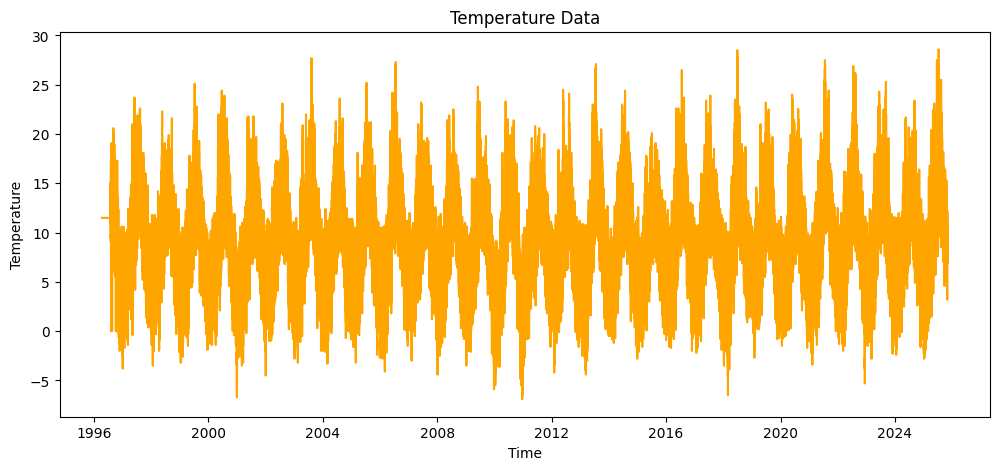

In [6]:

# Plotting temperature data.

temperature_data = df['temp']
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(12,5)) # Adjust the figure size as needed.
plt.plot(df['date'], df['temp'], color='orange')
plt.title('Temperature Data')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

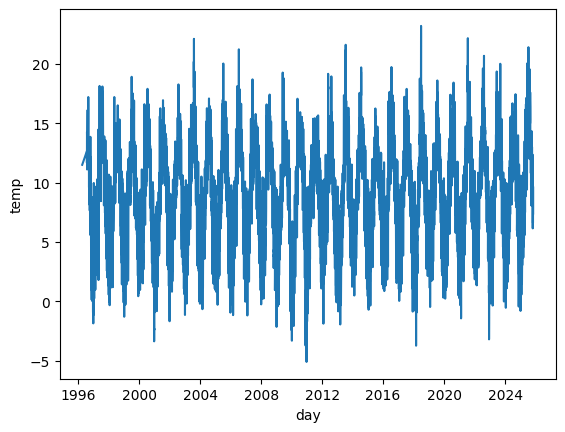

In [7]:
# Plotting the mean temperature each day.

df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')
df['day'] = df['date'].dt.date
daily_mean = df.groupby('day')['temp'].mean().reset_index()

sns.lineplot(data=daily_mean, x='day', y='temp')
plt.show()


#sns.lineplot(df[fields], x='date', y='temp')
